In [111]:
# Import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

In [63]:
traindf = pd.read_csv("Downloads/titanic/train.csv")
testdf = pd.read_csv('Downloads/titanic/test.csv')
gender_submission = pd.read_csv('Downloads/titanic/gender_submission.csv')

In [64]:
traindf.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [17]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


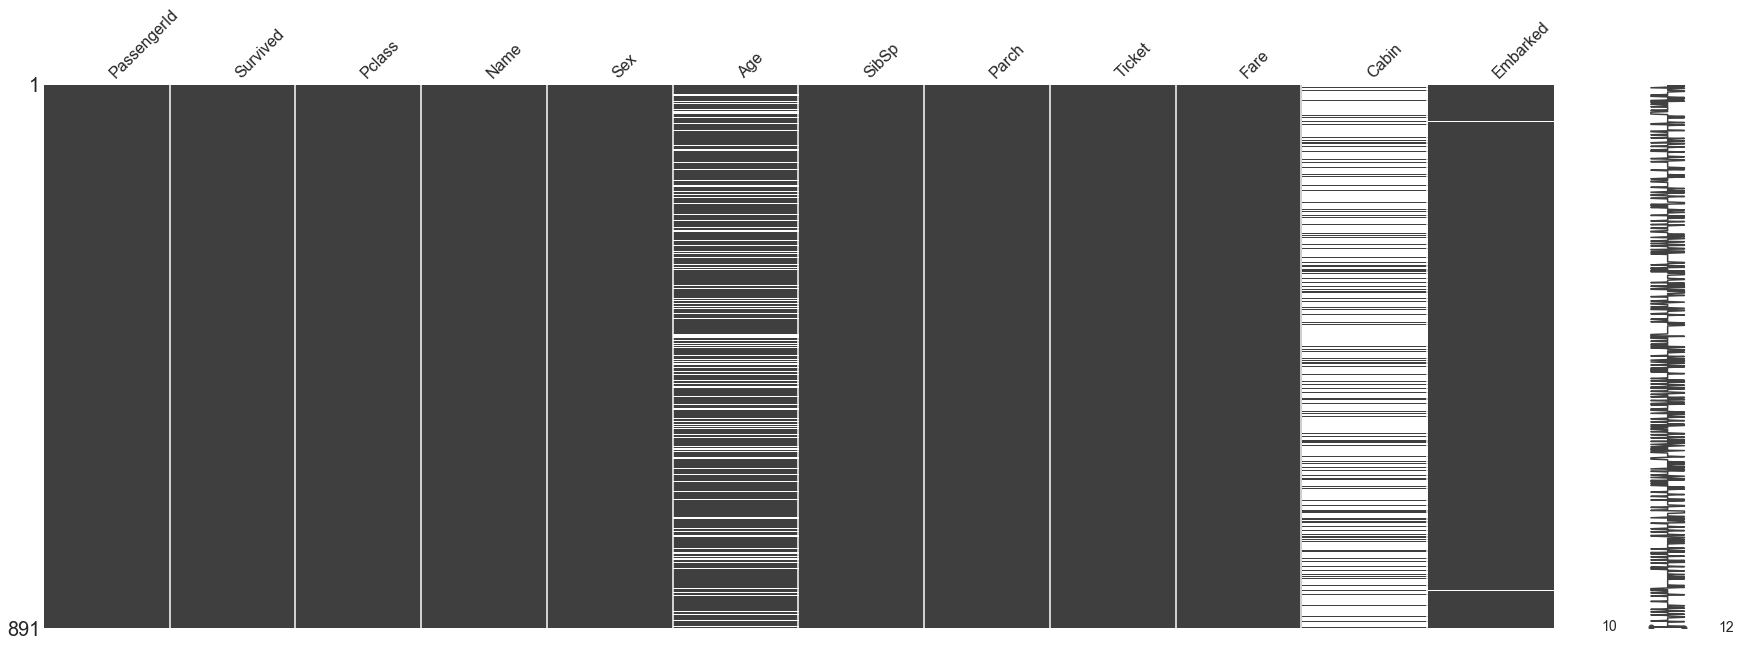

In [66]:
missingno.matrix(traindf, figsize = (30,10))

In [68]:
# Alternatively, you can see the number of missing values like this
traindf.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [18]:
testdf = pd.read_csv("Downloads/titanic/test.csv")

In [19]:
testdf.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


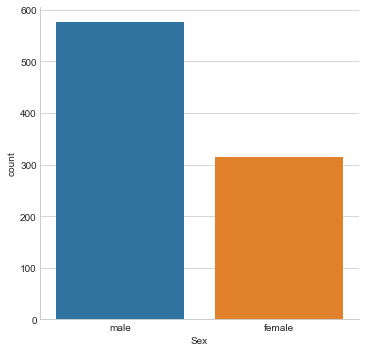

In [20]:
sns.catplot('Sex',data=traindf,kind="count")

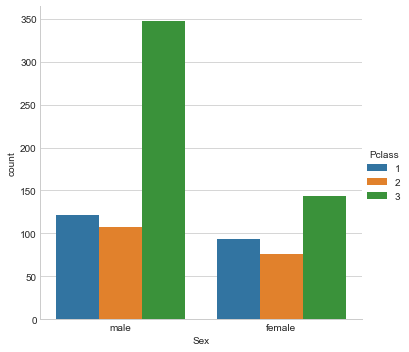

In [21]:
sns.catplot('Sex',data=traindf,kind='count',hue="Pclass")

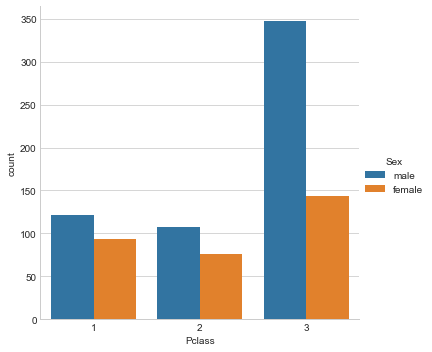

In [22]:
sns.catplot('Pclass',data=traindf,kind='count',hue="Sex")

In [23]:
def male_female_child(passenger):
    age,sex = passenger
    
    if age < 16:
        return 'child'
    else:
        return sex

In [24]:
traindf['person'] = traindf[['Age','Sex']].apply(male_female_child,axis=1)

In [25]:
traindf[0:10]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,person
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,male
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,female
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,female
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,female
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,male
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,male
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,male
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,child
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,female
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,child


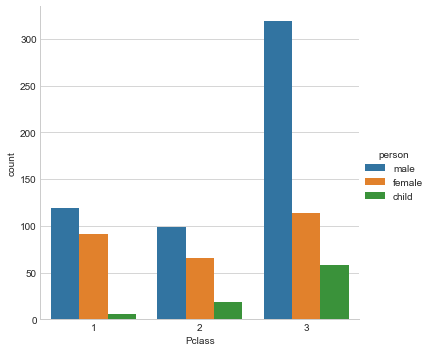

In [26]:
sns.catplot('Pclass',data=traindf,kind='count',hue='person')

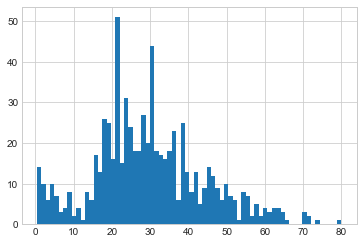

In [27]:
traindf['Age'].hist(bins=70)

In [28]:
traindf['Age'].mean()

29.69911764705882

In [29]:
traindf['person'].value_counts()

male      537
female    271
child      83
Name: person, dtype: int64

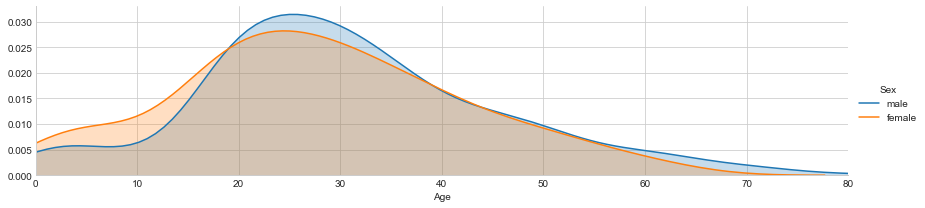

In [30]:
fig = sns.FacetGrid(traindf,hue='Sex',aspect=4)
fig.map(sns.kdeplot,'Age',shade=True)

oldest = traindf['Age'].max()

fig.set(xlim=(0,oldest))

fig.add_legend()

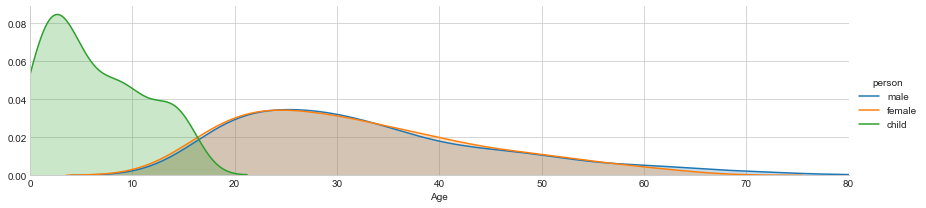

In [31]:
fig = sns.FacetGrid(traindf,hue='person',aspect=4)

fig.map(sns.kdeplot,'Age',shade=True)

oldest = traindf['Age'].max()

fig.set(xlim=(0,oldest))

fig.add_legend()

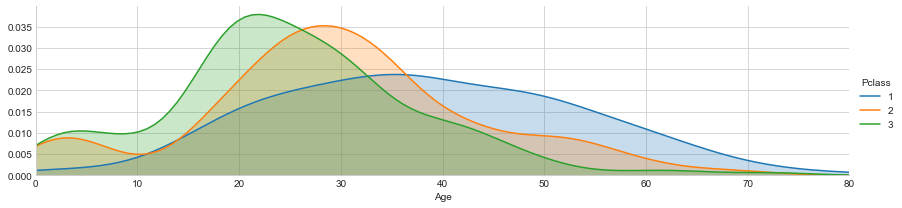

In [32]:
fig = sns.FacetGrid(traindf,hue='Pclass',aspect=4)

fig.map(sns.kdeplot,'Age',shade=True)

oldest = traindf['Age'].max()

fig.set(xlim=(0,oldest))

fig.add_legend()

In [33]:
deck = traindf['Cabin'].dropna()

In [34]:
deck.head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

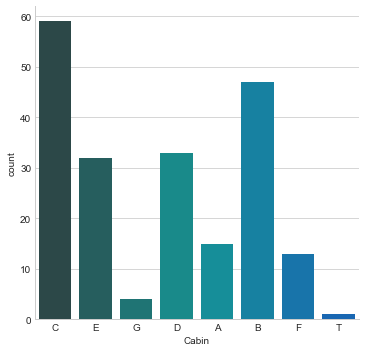

In [35]:
levels = []

for level in deck:
    levels.append(level[0])
    
cabin_df = DataFrame(levels)

cabin_df.columns = ['Cabin']

sns.catplot('Cabin',data=cabin_df,kind='count',palette='winter_d')

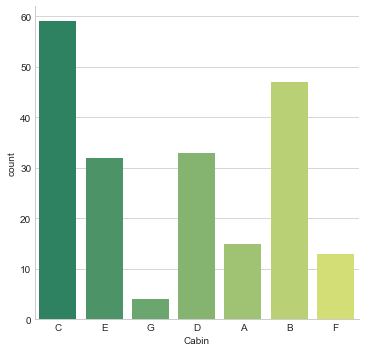

In [36]:
cabin_df = cabin_df[cabin_df.Cabin != 'T']
sns.catplot('Cabin',data=cabin_df,kind='count',palette='summer')

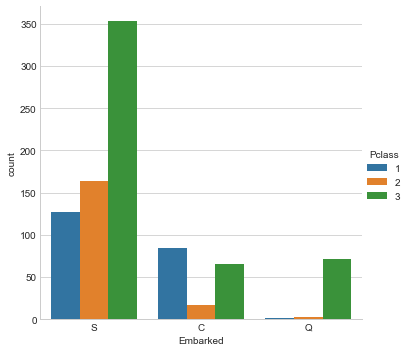

In [37]:
sns.catplot('Embarked',data=traindf,kind='count',hue='Pclass')

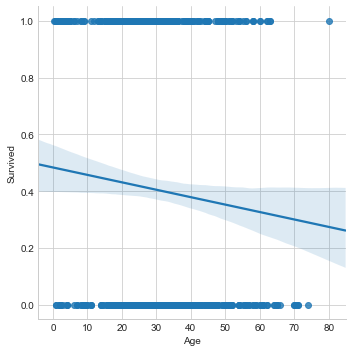

In [38]:
 sns.lmplot('Age','Survived',data=traindf)

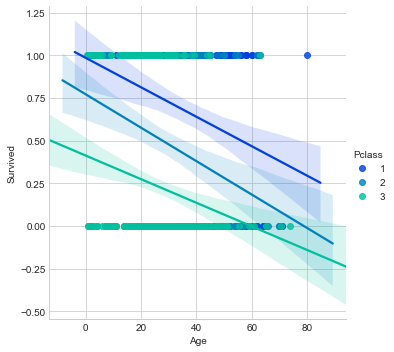

In [39]:
 sns.lmplot('Age','Survived',hue='Pclass',data=traindf,palette='winter')

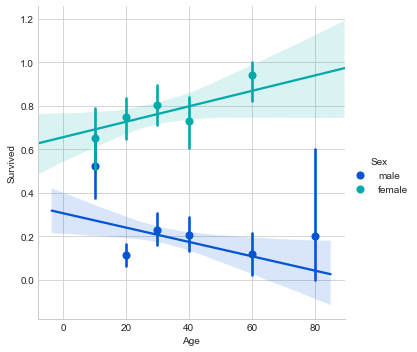

In [40]:
generations = [10,20,30,40,60,80]

sns.lmplot('Age','Survived',hue='Sex',data=traindf,palette='winter',x_bins=generations)

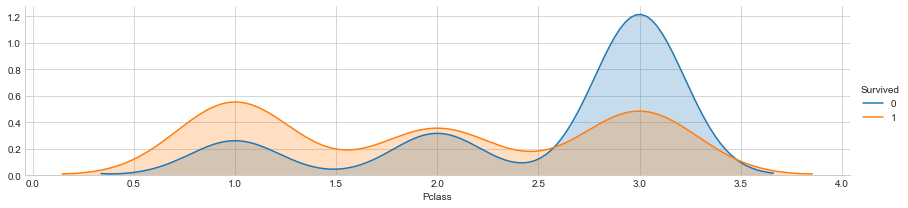

In [41]:
fig = sns.FacetGrid(traindf,hue='Survived',aspect=4)

fig.map(sns.kdeplot,'Pclass',shade=True)

fig.add_legend()

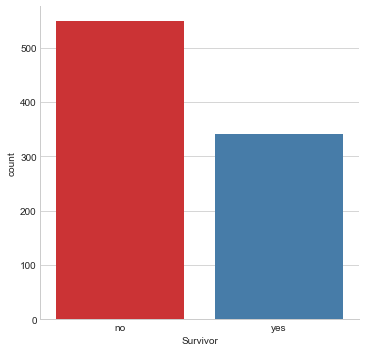

In [42]:
traindf['Survivor'] = traindf.Survived.map({0:'no',1:'yes'})

sns.catplot('Survivor',data=traindf,kind='count',palette='Set1')

In [ ]:
titanic_df[0:10]

In [ ]:
""""def male_female_child(passenger):
    age,sex = passenger
    
    if age < 16:
        return 'child'
    else:
        return sex"""

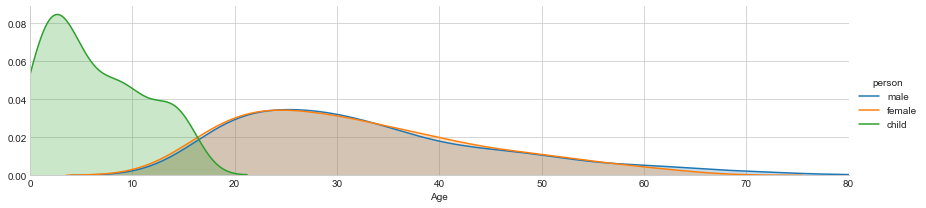

In [46]:
fig = sns.FacetGrid(traindf,hue='person',aspect=4)

fig.map(sns.kdeplot,'Age',shade=True)

oldest = traindf['Age'].max()

fig.set(xlim=(0,oldest))

fig.add_legend()

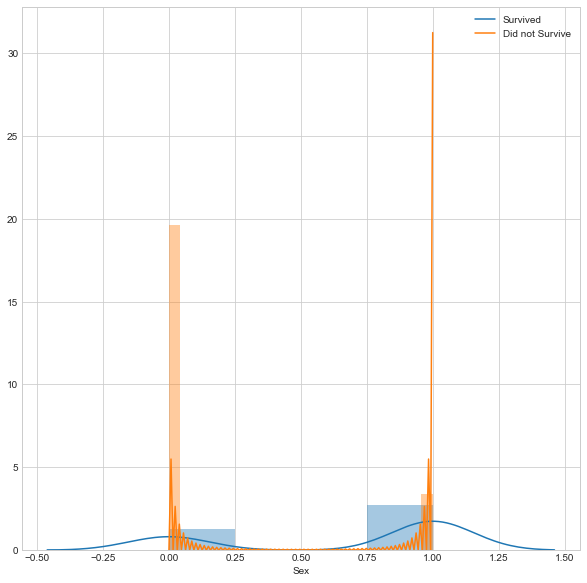

In [54]:
fig = plt.figure(figsize=(10,10))
sns.distplot(df_bin.loc[df_bin['Survived'] == 1]['Sex'], kde_kws={'label': 'Survived'});
sns.distplot(df_bin.loc[df_bin['Survived'] == 0]['Sex'], kde_kws={'label': 'Did not Survive'});

In [72]:
traindf.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

0    549
1    342
Name: Survived, dtype: int64


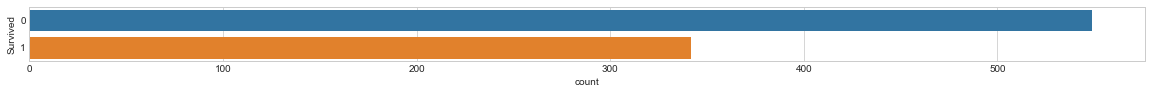

In [47]:
fig = plt.figure(figsize=(20,1))
sns.countplot(y='Survived', data=traindf);
print(traindf.Survived.value_counts())

In [74]:
# Add SibSp to subset dataframes
df_bin['SibSp'] = traindf['SibSp']
df_con['SibSp'] = traindf['SibSp']

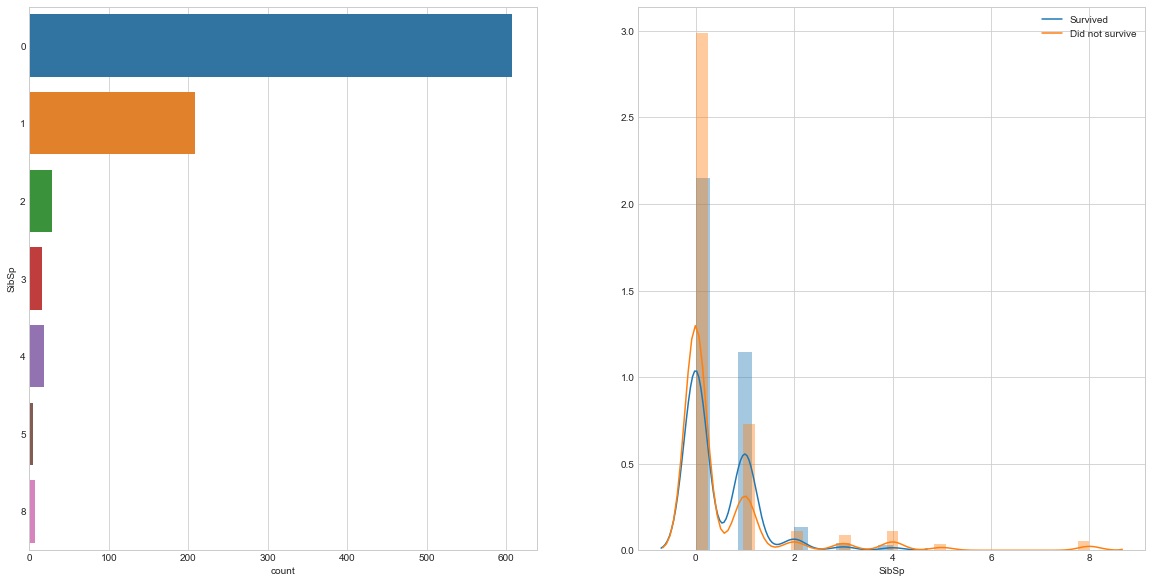

In [76]:
# Visualise the counts of SibSp and the distribution of the values
# against Survived
plot_count_dist(traindf, 
                bin_df=df_bin, 
                label_column='Survived', 
                target_column='SibSp', 
                figsize=(20, 10))

In [78]:
# Add Parch to subset dataframes
df_bin['Parch'] = traindf['Parch']
df_con['Parch'] = traindf['Parch']

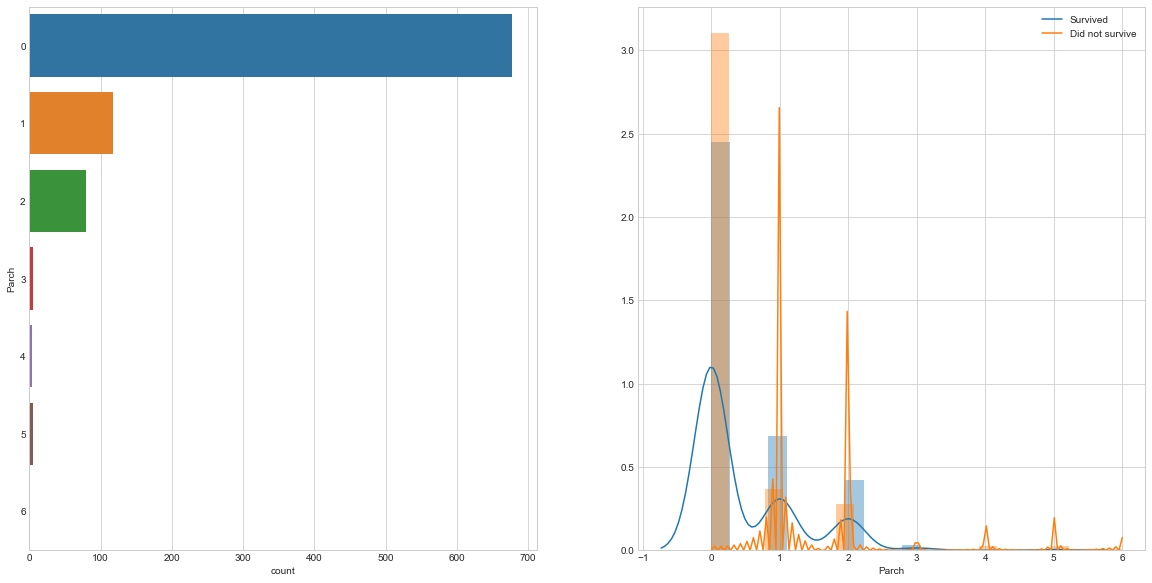

In [80]:
# Visualise the counts of Parch and the distribution of the values
# against Survived
plot_count_dist(traindf, 
                bin_df=df_bin,
                label_column='Survived', 
                target_column='Parch', 
                figsize=(20, 10))

In [81]:
df_con.head()

,Survived,Pclass,Sex,SibSp,Parch
0,0,3,male,1,0
1,1,1,female,1,0
2,1,3,female,0,0
3,1,1,female,1,0
4,0,3,male,0,0


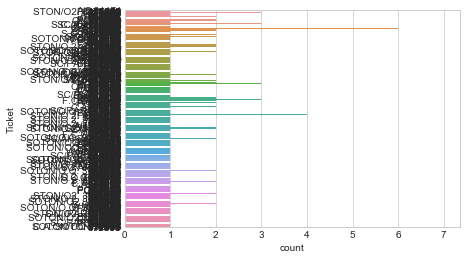

In [83]:
# How many kinds of ticket are there?
sns.countplot(y="Ticket", data=traindf);

In [87]:
df_con['Fare'] = traindf['Fare'] 
df_bin['Fare'] = pd.cut(traindf['Fare'], bins=5) # discretised

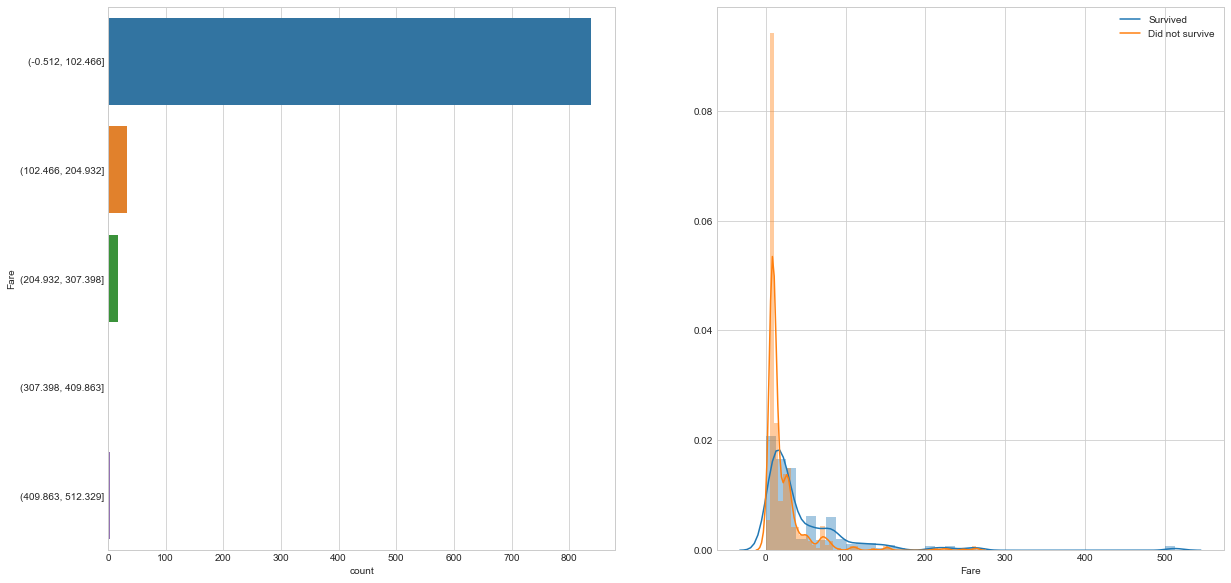

In [88]:
plot_count_dist(data=traindf,
                bin_df=df_bin,
                label_column='Survived', 
                target_column='Fare', 
                figsize=(20,10), 
                use_bin_df=True)

In [49]:
traindf.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object

In [50]:
df_bin['Survived'] = traindf['Survived']
df_con['Survived'] = traindf['Survived']

In [51]:
df_bin['Pclass'] = traindf['Pclass']
df_con['Pclass'] = traindf['Pclass']

In [52]:
df_bin['Sex'] = traindf['Sex']
df_bin['Sex'] = np.where(df_bin['Sex'] == 'female', 1, 0)
df_con['Sex'] = traindf['Sex']

In [58]:
df_bin.head()

,Survived,Pclass,Sex
0,0,3,0
1,1,1,1
2,1,3,1
3,1,1,1
4,0,3,0


In [69]:
def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20, 5), use_bin_df=False):
    """
    Function to plot counts and distributions of a label variable and 
    target variable side by side.
    ::param_data:: = target dataframe
    ::param_bin_df:: = binned dataframe for countplot
    ::param_label_column:: = binary labelled column
    ::param_target_column:: = column you want to view counts and distributions
    ::param_figsize:: = size of figure (width, height)
    ::param_use_bin_df:: = whether or not to use the bin_df, default False
    """
    if use_bin_df: 
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=bin_df);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});
    else:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=data);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});

In [90]:
df_bin['Embarked'] = traindf['Embarked']
df_con['Embarked'] = traindf['Embarked']

In [91]:
#Remove Embarked rows which are missing values
print(len(df_con))
df_con = df_con.dropna(subset=['Embarked'])
df_bin = df_bin.dropna(subset=['Embarked'])
print(len(df_con))

891
889


In [92]:
df_bin.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,0,1,0,"(-0.512, 102.466]",S
1,1,1,1,1,0,"(-0.512, 102.466]",C
2,1,3,1,0,0,"(-0.512, 102.466]",S
3,1,1,1,1,0,"(-0.512, 102.466]",S
4,0,3,0,0,0,"(-0.512, 102.466]",S


In [95]:
df_embarked_one_hot = pd.get_dummies(df_con['Embarked'], 
                                     prefix='embarked')

df_sex_one_hot = pd.get_dummies(df_con['Sex'], 
                                prefix='sex')

df_plcass_one_hot = pd.get_dummies(df_con['Pclass'], 
                                   prefix='pclass')

In [96]:
df_con_enc = pd.concat([df_con, 
                        df_embarked_one_hot, 
                        df_sex_one_hot, 
                        df_plcass_one_hot], axis=1)

# Drop the original categorical columns (because now they've been one hot encoded)
df_con_enc = df_con_enc.drop(['Pclass', 'Sex', 'Embarked'], axis=1)

In [97]:
# Seclect the dataframe we want to use first for predictions
selected_df = df_con_enc

In [98]:

# Split the dataframe into data and labels
X_train = selected_df.drop('Survived', axis=1) # data
y_train = selected_df.Survived # labels

In [99]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

# Logistic Regression

In [100]:

# Logistic Regression
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(), 
                                                               X_train, 
                                                               y_train, 
                                                                    10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 79.98
Accuracy CV 10-Fold: 79.42
Running Time: 0:01:47.617738


# Kneighbors

In [103]:

# k-Nearest Neighbours
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(), 
                                                  X_train, 
                                                  y_train, 
                                                  10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 83.46
Accuracy CV 10-Fold: 76.72
Running Time: 0:01:00.996388


# Guassian Naive Bayes

In [105]:

# Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, acc_gaussian, acc_cv_gaussian = fit_ml_algo(GaussianNB(), 
                                                                      X_train, 
                                                                      y_train, 
                                                                           10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 78.52
Accuracy CV 10-Fold: 77.95
Running Time: 0:01:07.265398


# Support Vector Machines

In [106]:
# Linear SVC
start_time = time.time()
train_pred_svc, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(LinearSVC(),
                                                                X_train, 
                                                                y_train, 
                                                                10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 79.98
Accuracy CV 10-Fold: 75.93
Running Time: 0:00:31.455569


# Stochastic Gradient Descent

In [107]:
# Stochastic Gradient Descent
start_time = time.time()
train_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(), 
                                                  X_train, 
                                                  y_train,
                                                  10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 71.65
Accuracy CV 10-Fold: 68.05
Running Time: 0:00:22.261029


# Decision tree classifier

In [108]:

# Decision Tree Classifier
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                                X_train, 
                                                                y_train,
                                                                10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 92.46
Accuracy CV 10-Fold: 79.98
Running Time: 0:00:24.377032


# Gradient Boost

In [109]:
# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                       X_train, 
                                                                       y_train,
                                                                       10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 86.61
Accuracy CV 10-Fold: 80.65
Running Time: 0:00:33.377319


In [113]:
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features

array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [114]:
# Use the CatBoost Pool() function to pool together the training data and categorical feature labels
train_pool = Pool(X_train, 
                  y_train,
                  cat_features)

In [115]:

# CatBoost model definition
catboost_model = CatBoostClassifier(iterations=1000,
                                    custom_loss=['Accuracy'],
                                    loss_function='Logloss')

# Fit CatBoost model
catboost_model.fit(train_pool,
                   plot=True)

# CatBoost accuracy
acc_catboost = round(catboost_model.score(X_train, y_train) * 100, 2)

Learning rate set to 0.016206
0:	learn: 0.6818450	total: 2.33s	remaining: 38m 51s
1:	learn: 0.6759072	total: 2.44s	remaining: 20m 16s
2:	learn: 0.6673021	total: 2.48s	remaining: 13m 44s
3:	learn: 0.6588371	total: 2.51s	remaining: 10m 24s
4:	learn: 0.6509958	total: 2.55s	remaining: 8m 27s
5:	learn: 0.6426722	total: 2.64s	remaining: 7m 17s
6:	learn: 0.6353671	total: 2.66s	remaining: 6m 17s
7:	learn: 0.6278300	total: 2.79s	remaining: 5m 45s
8:	learn: 0.6199946	total: 2.89s	remaining: 5m 17s
9:	learn: 0.6157245	total: 2.94s	remaining: 4m 51s
10:	learn: 0.6093044	total: 2.99s	remaining: 4m 29s
11:	learn: 0.6019208	total: 3.04s	remaining: 4m 10s


12:	learn: 0.5944882	total: 3.77s	remaining: 4m 46s


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

13:	learn: 0.5880221	total: 4.06s	remaining: 4m 46s
14:	learn: 0.5837337	total: 4.24s	remaining: 4m 38s
15:	learn: 0.5777183	total: 4.29s	remaining: 4m 24s
16:	learn: 0.5724198	total: 4.33s	remaining: 4m 10s
17:	learn: 0.5670410	total: 4.39s	remaining: 3m 59s
18:	learn: 0.5619492	total: 4.45s	remaining: 3m 49s
19:	learn: 0.5575732	total: 4.48s	remaining: 3m 39s
20:	learn: 0.5533704	total: 4.52s	remaining: 3m 30s
21:	learn: 0.5496095	total: 4.58s	remaining: 3m 23s
22:	learn: 0.5447682	total: 4.66s	remaining: 3m 17s
23:	learn: 0.5398395	total: 4.73s	remaining: 3m 12s
24:	learn: 0.5374627	total: 4.78s	remaining: 3m 6s
25:	learn: 0.5323946	total: 4.84s	remaining: 3m 1s
26:	learn: 0.5283429	total: 4.93s	remaining: 2m 57s
27:	learn: 0.5262992	total: 5s	remaining: 2m 53s
28:	learn: 0.5241094	total: 5.01s	remaining: 2m 47s
29:	learn: 0.5212465	total: 5.02s	remaining: 2m 42s
30:	learn: 0.5189036	total: 5.04s	remaining: 2m 37s
31:	learn: 0.5155128	total: 5.07s	remaining: 2m 33s
32:	learn: 0.5122

# Catboost Cross validation

In [116]:
# How long will this take?
start_time = time.time()

# Set params for cross-validation as same as initial model
cv_params = catboost_model.get_params()

# Run the cross-validation for 10-folds (same as the other models)
cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)

# How long did it take?
catboost_time = (time.time() - start_time)

# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6740233	test: 0.6747274	best: 0.6747274 (0)	total: 23s	remaining: 6h 22m 13s
1:	learn: 0.6556334	test: 0.6573982	best: 0.6573982 (1)	total: 41.5s	remaining: 5h 44m 45s
2:	learn: 0.6390043	test: 0.6417160	best: 0.6417160 (2)	total: 49.1s	remaining: 4h 31m 56s
3:	learn: 0.6254821	test: 0.6285888	best: 0.6285888 (3)	total: 56.4s	remaining: 3h 53m 58s
4:	learn: 0.6108179	test: 0.6145866	best: 0.6145866 (4)	total: 1m 2s	remaining: 3h 28m 19s
5:	learn: 0.5983980	test: 0.6025400	best: 0.6025400 (5)	total: 1m 10s	remaining: 3h 13m 38s
6:	learn: 0.5875155	test: 0.5927693	best: 0.5927693 (6)	total: 1m 16s	remaining: 3h 1m 49s
7:	learn: 0.5756412	test: 0.5818428	best: 0.5818428 (7)	total: 1m 24s	remaining: 2h 54m 46s
8:	learn: 0.5653070	test: 0.5721953	best: 0.5721953 (8)	total: 1m 31s	remaining: 2h 48m 24s
9:	learn: 0.5570628	test: 0.5642644	best: 0.5642644 (9)	total: 1m 38s	remaining: 2h 43m 9s
10:	learn: 0.5487046	test: 0.5565424	best: 0.5565424 (10)	total: 1m 46s	remaining: 2h 40m

In [117]:

# Print out the CatBoost model metrics
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy cross-validation 10-Fold: {}".format(acc_cv_catboost))
print("Running Time: {}".format(datetime.timedelta(seconds=catboost_time)))

---CatBoost Metrics---
Accuracy: 86.16
Accuracy cross-validation 10-Fold: 81.44
Running Time: 2:23:32.284208


In [118]:

cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,      
        acc_cv_gaussian, 
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt,
        acc_cv_catboost
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


,Model,Score
7,CatBoost,81.44
6,Gradient Boosting Trees,80.65
5,Decision Tree,79.98
1,Logistic Regression,79.42
2,Naive Bayes,77.95
0,KNN,76.72
4,Linear SVC,75.93
3,Stochastic Gradient Decent,68.05


In [119]:

cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,      
        acc_cv_gaussian, 
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt,
        acc_cv_catboost
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


,Model,Score
7,CatBoost,81.44
6,Gradient Boosting Trees,80.65
5,Decision Tree,79.98
1,Logistic Regression,79.42
2,Naive Bayes,77.95
0,KNN,76.72
4,Linear SVC,75.93
3,Stochastic Gradient Decent,68.05


In [123]:
# One hot encode the columns in the test data frame (like X_train)
test_embarked_one_hot = pd.get_dummies(testdf['Embarked'], 
                                       prefix='embarked')

test_sex_one_hot = pd.get_dummies(testdf['Sex'], 
                                prefix='sex')

test_plcass_one_hot = pd.get_dummies(testdf['Pclass'], 
                                   prefix='pclass')

In [126]:
# Combine the test one hot encoded columns with test
testdf = pd.concat([testdf, 
                  test_embarked_one_hot, 
                  test_sex_one_hot, 
                  test_plcass_one_hot], axis=1)

In [127]:
wanted_test_columns = X_train.columns
wanted_test_columns

Index(['SibSp', 'Parch', 'Fare', 'embarked_C', 'embarked_Q', 'embarked_S',
       'sex_female', 'sex_male', 'pclass_1', 'pclass_2', 'pclass_3'],
      dtype='object')

In [130]:
# Make a prediction using the CatBoost model on the wanted columns
predictions = catboost_model.predict(testdf[wanted_test_columns])

In [131]:
submission = pd.DataFrame()
submission['PassengerId'] = testdf['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset
submission.head()

,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,1.0


In [132]:
# Let's convert our submission dataframe 'Survived' column to ints
submission['Survived'] = submission['Survived'].astype(int)
print('Converted Survived column to integers.')

Converted Survived column to integers.


# completed data for final submission

In [133]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [135]:
# Are our test and submission dataframes the same length?
if len(submission) == len(testdf):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [137]:
# Convert submisison dataframe to csv for submission to csv 
# for Kaggle submisison
submission.to_csv('Downloads/titanic/catboost_submission.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [138]:
submissions_check = pd.read_csv("Downloads/titanic/catboost_submission.csv")
submissions_check.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
